# Milestone Project 2: SkimLit 🔥📄

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset we'll be using) is avalible [here](https://arxiv.org/abs/1710.06071).

And reading through the paper above, we see that the model architecture that they use to achieve their best results is avilable [here](https://arxiv.org/abs/1612.05251).



# Confirm access to a GPU

In [1]:
!nvidia-smi

Wed Jun  5 19:25:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used

WE can do so from the authors GitHub: [link](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 21.89 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start our experimnets using the 20k dataset with numbers replaced by "@" sign"
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.
And one of the best way is to visualize

Let's create a function to read in all of the lines of a target text file

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of a text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")

In [8]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look

How i think our data would be best represented



In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 422 ms, sys: 107 ms, total: 530 ms
Wall time: 527 ms


(180040, 30212, 30135)

In [11]:
# Check teh first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it.

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distrubution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

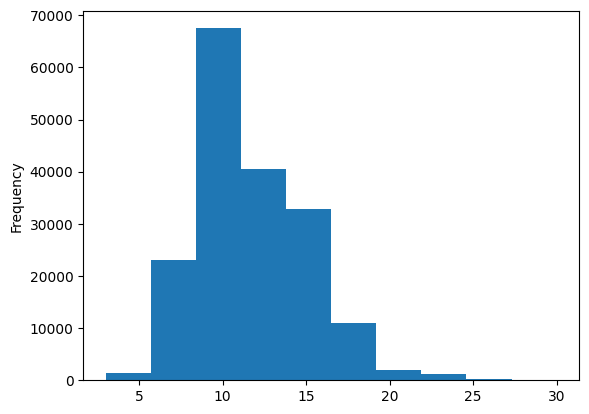

In [15]:
# Check the lenght of differnet lines
train_df.total_lines.plot.hist()

### Get list of centences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences),

(180040, 30212, 30135)

In [17]:
# View the 10 first lines of train sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML require numeric labels)

In [18]:
import sklearn
print(sklearn.__version__)

1.2.2


In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_label_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_label_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
import tensorflow as tf
tf.constant(train_label_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [21]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments..

As usual, we're going to be trying out a bunch of different models and seeing wich one works best.![2024-05-10_2.png](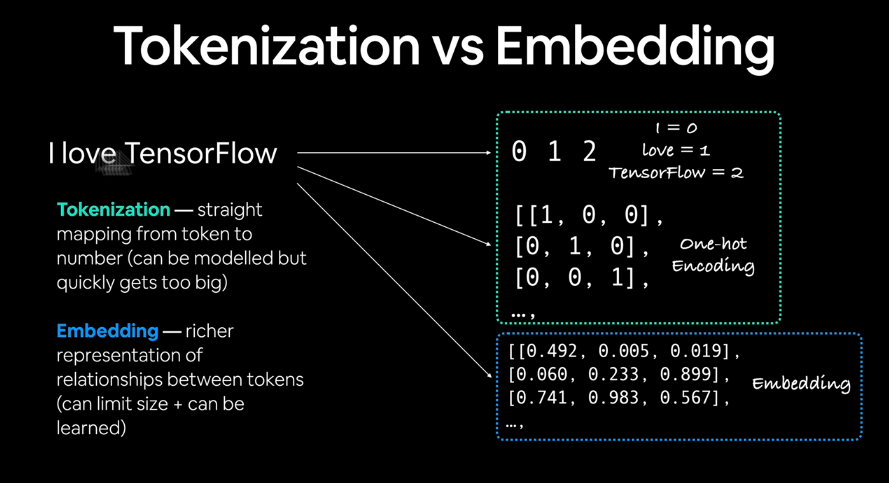![2024-05-11_2.png](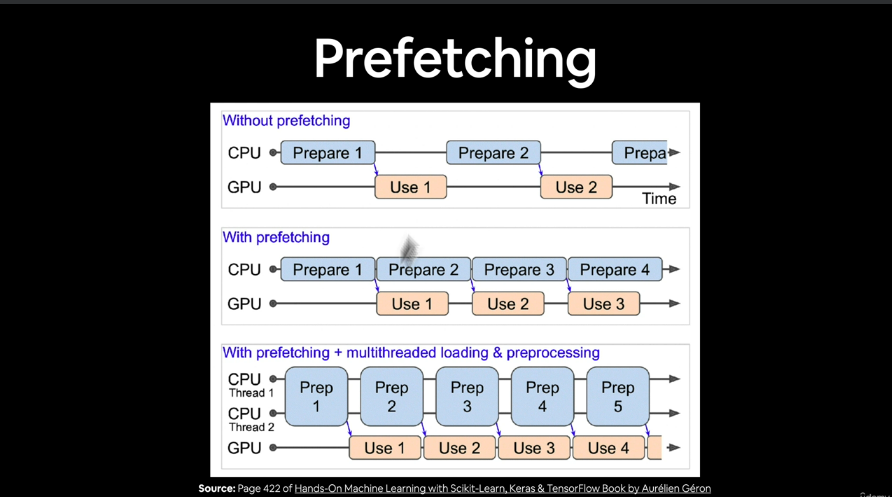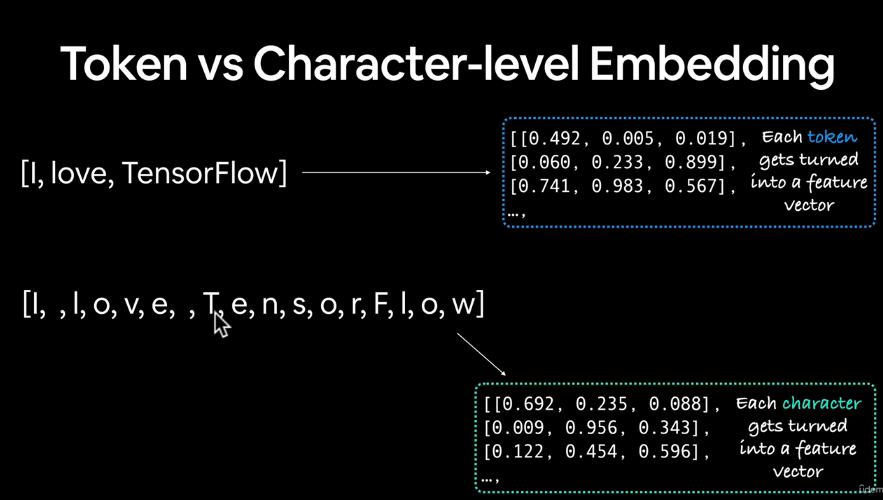))


## Model 0: Getting a baseline


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [25]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
### Download helper function script
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py -O helper.py

--2024-06-05 19:25:55--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13380 (13K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  13.07K  --.-KB/s    in 0.001s  

2024-06-05 19:25:55 (17.8 MB/s) - ‘helper.py’ saved [13380/13380]



In [27]:
from helper import calculate_results

In [28]:
# Calculate baseline reults
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models,we've got to create vectorization and embedding layers.

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [31]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

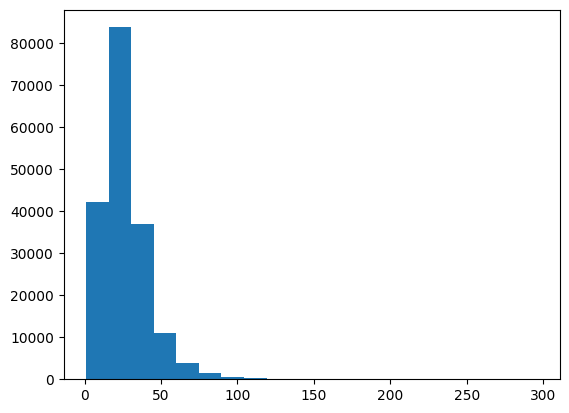

In [32]:
# Whats the distrubution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [33]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [34]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Creating text vectorizer layer

We want to make a layer wich maps our texts from words to numbers.

In [35]:
# How many words are in our vocabulay?
max_tokens = 68000

In [36]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [37]:
# Adapt text vectorizer to trainig sentences
text_vectorizer.adapt(train_sentences)

In [38]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
completion data was not available for the noninteractive version ( no way to record it automatically ) .

Length of text: 18

Vectorized text: [[ 1028   100    10    31   559    11     2 25502  1451    33  1767     6
   2420   185  6706     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [40]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding

In [41]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=512, # different embedding sizes result in drastically differnt numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequnce lengths (save space)
                               name="token_embedding")

In [42]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 completion data was not available for the noninteractive version ( no way to record it automatically ) .

Sentence after vectorization (before embedding):
 [[ 1028   100    10    31   559    11     2 25502  1451    33  1767     6
   2420   185  6706     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.00789274 -0.02745243 -0.00965424 ... -0.04497964  0.03948566
   -0.00377296]
  [ 0.01523272  0.04639336  0.04137978 ...  0.02289578  0.04977936
    0.01275288]
  [-0.0246066  -0.03166274  0.02559305 ... -0.03260519 -0.01030115
    0.01051124]
  ...
  [-0.04813508 -0.02927711  0.0078946  ...  0.01637398  0.0038924
   -0.0086061 ]
  [-0.04813508 -0.02927711  0.0078946  ...  0.01637398  0.0038924
   -0.0086061 ]
  [-0.04813508 -0.02927

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* [data_performance](https://www.tensorflow.org/guide/data_performance)
* [data](https://www.tensorflow.org/guide/data)

In [43]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_label_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [44]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [45]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 512)           33198592  
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            163904    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [47]:
# Fit the model, on 10% of the data to save time
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=10,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 23s 35ms/step - loss: 0.8305 - accuracy: 0.6765 - val_loss: 0.6542 - val_accuracy: 0.7613
Epoch 2/10
562/562 [==============================] - 9s 16ms/step - loss: 0.6326 - accuracy: 0.7713 - val_loss: 0.6087 - val_accuracy: 0.7816
Epoch 3/10
562/562 [==============================] - 8s 14ms/step - loss: 0.5962 - accuracy: 0.7845 - val_loss: 0.5734 - val_accuracy: 0.7922
Epoch 4/10
562/562 [==============================] - 7s 12ms/step - loss: 0.5699 - accuracy: 0.7975 - val_loss: 0.5596 - val_accuracy: 0.7942
Epoch 5/10
562/562 [==============================] - 8s 14ms/step - loss: 0.5763 - accuracy: 0.7958 - val_loss: 0.5416 - val_accuracy: 0.8049
Epoch 6/10
562/562 [==============================] - 8s 14ms/step - loss: 0.5646 - accuracy: 0.7948 - val_loss: 0.5376 - val_accuracy: 0.8115
Epoch 7/10
562/562 [==============================] - 8s 14ms/step - loss: 0.5441 - accuracy: 0.8020 - val_loss: 0.5251 - val_accuracy: 0.812

In [48]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5096 - accuracy: 0.8157


[0.5096209049224854, 0.8156692981719971]

In [49]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[6.2624860e-01, 1.0158612e-01, 8.2934730e-02, 1.3511278e-01,
        5.4117847e-02],
       [4.5631757e-01, 2.9712939e-01, 7.4664517e-03, 2.0232593e-01,
        3.6760662e-02],
       [2.0653956e-01, 7.2417897e-03, 1.4322528e-03, 7.8469831e-01,
        8.8040077e-05],
       ...,
       [3.7801806e-06, 8.2627121e-05, 2.2146576e-03, 2.1993023e-06,
        9.9769670e-01],
       [5.3854719e-02, 7.2331870e-01, 5.3172670e-02, 3.2108691e-02,
        1.3754524e-01],
       [2.0087438e-02, 9.5779413e-01, 1.6625397e-02, 9.0169953e-04,
        4.5913584e-03]], dtype=float32)

In [50]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [51]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.56692704885477,
 'precision': 0.8120708967729822,
 'recall': 0.8156692704885476,
 'f1': 0.8124432887102674}

In [52]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from tensorflow Hub, more specifically the [universal sentence encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

In [53]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=True, # True if you want to train the whole model,like 256 million layers
                                        name="universal_sentence_encoder")

In [54]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence: 
 a total of @ healthy chinese men were enrolled in the study .
Sentence after embedding:
 [[ 1.82534177e-02  2.33060028e-02 -4.92999479e-02  1.22959102e-02
  -1.13195824e-02  3.21856700e-02  2.06046086e-02  1.67795327e-02
  -5.70919067e-02 -1.16565106e-02 -4.43938300e-02  1.51646705e-02
   2.03351136e-02  2.91543659e-02 -3.89055423e-02 -2.42675766e-02
  -3.96718755e-02  1.61464550e-02  3.34339612e-03 -6.50112331e-02
  -6.98377118e-02  7.75018940e-03 -2.91777384e-02 -2.22266205e-02
  -9.50051995e-04  5.78439124e-02  2.01626793e-02  4.59376946e-02
   3.06491368e-02  1.90163776e-02  3.61749679e-02  9.54307690e-02
  -8.88651144e-03  1.01093939e-02 -2.22744886e-02  4.31479067e-02
  -8.52628499e-02 -5.24267852e-02 -3.36880349e-02  1.35133862e-02
  -2.35108640e-02  7.78868198e-02 -1.85260326e-02 -9.39428620e-03
   4.72624153e-02 -1.27346208e-02 -9.51114018e-03  7.59992450e-02
  -2.70856563e-02 -3.21233310e-02 -2.48485170e-02 -3.99189740e-02
   2.92710457e-02  5.49230899e-04 

## Building and fitting NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [55]:
# Define feature extraction model using TF hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(512, activation="relu")(pretrained_embedding)
# You could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 257063045 (980.62 MB)
Trainable params: 257063045 (980.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=10,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 168s 248ms/step - loss: 0.7347 - accuracy: 0.7154 - val_loss: 0.5552 - val_accuracy: 0.7829
Epoch 2/10
562/562 [==============================] - 55s 98ms/step - loss: 0.5553 - accuracy: 0.7945 - val_loss: 0.5197 - val_accuracy: 0.7995
Epoch 3/10
562/562 [==============================] - 52s 92ms/step - loss: 0.5224 - accuracy: 0.8048 - val_loss: 0.4939 - val_accuracy: 0.8112
Epoch 4/10
562/562 [==============================] - 51s 92ms/step - loss: 0.4996 - accuracy: 0.8167 - val_loss: 0.4733 - val_accuracy: 0.8201
Epoch 5/10
562/562 [==============================] - 51s 90ms/step - loss: 0.5019 - accuracy: 0.8161 - val_loss: 0.4779 - val_accuracy: 0.8191
Epoch 6/10
562/562 [==============================] - 50s 89ms/step - loss: 0.4936 - accuracy: 0.8165 - val_loss: 0.4540 - val_accuracy: 0.8301
Epoch 7/10
562/562 [==============================] - 49s 88ms/step - loss: 0.4718 - accuracy: 0.8260 - val_loss: 0.4563 - val_accurac

In [58]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.4399 - accuracy: 0.8365


[0.4399162530899048, 0.8364557027816772]

In [59]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[2.6171821e-01, 6.3032454e-01, 2.6773543e-03, 9.0675332e-02,
        1.4604593e-02],
       [6.7988026e-01, 9.0422198e-02, 1.8192274e-03, 2.2673844e-01,
        1.1398409e-03],
       [3.2301840e-01, 7.8280974e-04, 4.3553240e-03, 6.7166692e-01,
        1.7650524e-04],
       ...,
       [1.0627362e-04, 4.9768109e-04, 3.6254721e-03, 6.6134489e-06,
        9.9576390e-01],
       [1.3736234e-02, 7.1380115e-01, 7.0465021e-03, 5.2417023e-03,
        2.6017445e-01],
       [5.2592354e-03, 9.8555577e-01, 5.8733230e-04, 1.4619320e-03,
        7.1358327e-03]], dtype=float32)

In [60]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 1, 1])>

In [61]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 83.6455712961737,
 'precision': 0.8360055821411037,
 'recall': 0.836455712961737,
 'f1': 0.8343432759753346}

In [62]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 3: Conv1D with charachter embeddings


### Create a charachter-level toknizer


In [63]:
# Make a function to split sentences into charachters
def split_chars(text):
  return " ".join(list(text))

In [64]:
# Text splitting non-characher-level sequence into charachters
split_chars(random_train_sentence)

'a   t o t a l   o f   @   h e a l t h y   c h i n e s e   m e n   w e r e   e n r o l l e d   i n   t h e   s t u d y   .'

In [65]:
# Split sequence-level data splits into char-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# What's the average charachter length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

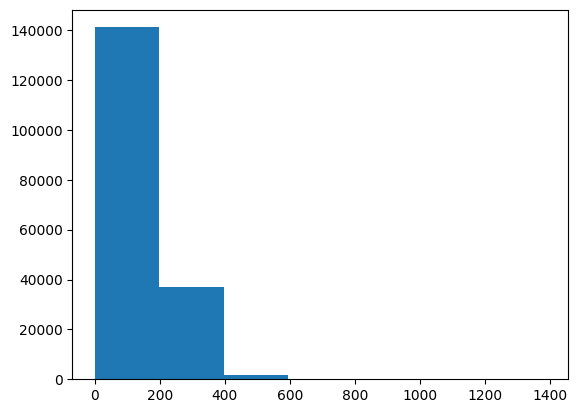

In [67]:
# Check the distribution of our sequences at a charachter-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [68]:
# Find what charachter length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
# Get all keyboard charachters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [71]:
# Adapt char vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different charachters in character vocab: {len(char_vocab)}")
print(f"5 most common charachters: {char_vocab[:5]}")
print(f"5 least common charachters: {char_vocab[-5:]}")

Number of different charachters in character vocab: 28
5 most common charachters: ['', '[UNK]', 'e', 't', 'i']
5 least common charachters: ['k', 'x', 'z', 'q', 'j']


In [73]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e s e   r e s u l t s   s h o w   t h a t   f l u i d   r e s t r i c t i o n   m a n a g e m e n t   f o r   o l t   d e c r e a s e d   b l o o d   p r o d u c t s   r e q u i r e m e n t s   ,   e s p e c i a l l y   f f p   .

Length of random_train_chars: 101

Vectorized chars:
 [[ 3 13  2  9  2  8  2  9 16 12  3  9  9 13  7 20  3 13  5  3 17 12 16  4
  10  8  2  9  3  8  4 11  3  4  7  6 15  5  6  5 18  2 15  2  6  3 17  7
   8  7 12  3 10  2 11  8  2  5  9  2 10 22 12  7  7 10 14  8  7 10 16 11
   3  9  8  2 26 16  4  8  2 15  2  6  3  9  2  9 14  2 11  4  5 12 12 19
  17 17 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0

## Creater a charachter-level embedding

In [74]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), #number of different charachters
                              output_dim=25,
                              mask_zero=True,
                              name="cahr_embed")

In [75]:
# Test our charachter embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Charachter embed shape: {char_embed_example.shape}")

Charified text:
 t h e s e   r e s u l t s   s h o w   t h a t   f l u i d   r e s t r i c t i o n   m a n a g e m e n t   f o r   o l t   d e c r e a s e d   b l o o d   p r o d u c t s   r e q u i r e m e n t s   ,   e s p e c i a l l y   f f p   .

Embedded chars. (after vectorization and embedding):
 [[[ 0.03146208 -0.04215365  0.04470415 ...  0.00772347  0.04883576
   -0.01057916]
  [ 0.01681745  0.04589352  0.00956796 ...  0.02101002 -0.0217325
   -0.01559267]
  [ 0.03337983  0.01736364  0.00341678 ... -0.03680978  0.00356395
   -0.04735191]
  ...
  [ 0.02795767  0.02116943  0.03718238 ...  0.00604675  0.0264594
    0.00768398]
  [ 0.02795767  0.02116943  0.03718238 ...  0.00604675  0.0264594
    0.00768398]
  [ 0.02795767  0.02116943  0.03718238 ...  0.00604675  0.0264594
    0.00768398]]]

Charachter embed shape: (1, 290, 25)


### Building a Conv1D to fit on charachter embeddings

In [76]:
# Make Cinv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 cahr_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [78]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [79]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2635 - accuracy: 0.4967 - val_loss: 1.0392 - val_accuracy: 0.5981
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0024 - accuracy: 0.5980 - val_loss: 0.9443 - val_accuracy: 0.6340
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9321 - accuracy: 0.6353 - val_loss: 0.8711 - val_accuracy: 0.6722


In [80]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8866 - accuracy: 0.6575


[0.8865892887115479, 0.6575201749801636]

In [81]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.11727741, 0.39588273, 0.06328904, 0.35422593, 0.06932482],
       [0.18615231, 0.64649373, 0.0123241 , 0.06487721, 0.09015261],
       [0.1336733 , 0.4228268 , 0.07081245, 0.3527956 , 0.01989189],
       ...,
       [0.01487626, 0.02805038, 0.13832013, 0.02981278, 0.7889404 ],
       [0.0334555 , 0.10028917, 0.14021003, 0.04172802, 0.68431723],
       [0.36961523, 0.4687177 , 0.07508703, 0.05685274, 0.02972736]],
      dtype=float32)

In [82]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [83]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.75201906527208,
 'precision': 0.6516998868927547,
 'recall': 0.6575201906527208,
 'f1': 0.6472796175645384}

## Model 4: Combining pretrained token embeddings + charachter embeddings (hybrid embedding layer)

1. Create a token level embedding model (similar `model_1`)
2. Create a charachter level model (similar `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.concatenate`)
4. Build a series of output layers on top of 3
5. Construct a model that take token and charachter-level sequences as input and produces sequence label probabilities as output

In [84]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(300, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_ltsm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_ltsm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.input],
                         outputs=output_layer,
                         name="model_4_tken_and_char_embeddings")

In [85]:
# Summary
model_4.summary()

Model: "model_4_tken_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978  

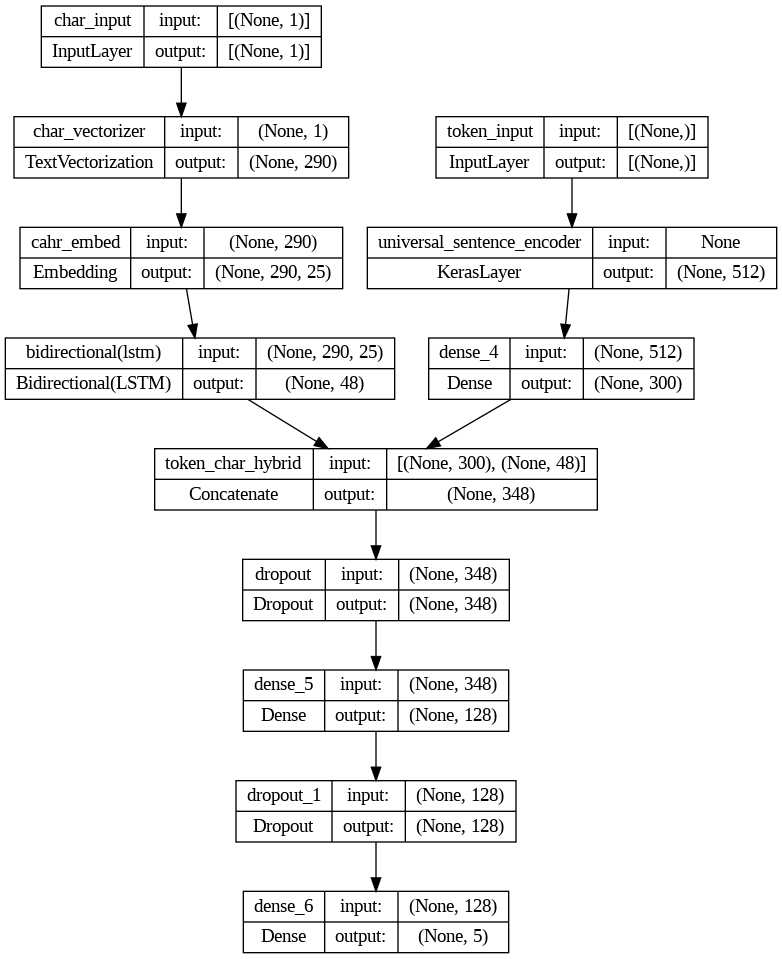

In [89]:
# Plot hybrid token and charachter model
# Trainable isnt false
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [90]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Combining token and charachter data into a tf.data Dataset

In [91]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labesl = tf.data.Dataset.from_tensor_slices((train_label_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labesl)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [93]:
# Repeat above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labesl = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labesl)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and charachter-level sequneces

In [95]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 213s 318ms/step - loss: 0.4125 - accuracy: 0.8647 - val_loss: 0.5073 - val_accuracy: 0.8235
Epoch 2/10
562/562 [==============================] - 97s 173ms/step - loss: 0.2795 - accuracy: 0.9081 - val_loss: 0.5096 - val_accuracy: 0.8201
Epoch 3/10
562/562 [==============================] - 77s 137ms/step - loss: 0.2590 - accuracy: 0.9139 - val_loss: 0.5387 - val_accuracy: 0.8168
Epoch 4/10
562/562 [==============================] - 87s 155ms/step - loss: 0.2484 - accuracy: 0.9194 - val_loss: 0.5345 - val_accuracy: 0.8245
Epoch 5/10
562/562 [==============================] - 92s 164ms/step - loss: 0.2483 - accuracy: 0.9206 - val_loss: 0.5589 - val_accuracy: 0.8231
Epoch 6/10
562/562 [==============================] - 71s 126ms/step - loss: 0.2450 - accuracy: 0.9179 - val_loss: 0.5624 - val_accuracy: 0.8281
Epoch 7/10
562/562 [==============================] - 73s 131ms/step - loss: 0.2308 - accuracy: 0.9220 - val_loss: 0.5860 - val_a

In [96]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.5729 - accuracy: 0.8183


[0.5729441046714783, 0.8182841539382935]

In [97]:
# Make predictions using the token_charachter model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 22s 21ms/step


array([[2.1158452e-01, 6.6575712e-01, 6.0959882e-04, 1.1931194e-01,
        2.7368029e-03],
       [6.2920642e-01, 6.7217094e-03, 7.1940961e-04, 3.6314821e-01,
        2.0422421e-04],
       [5.8650855e-02, 1.1921297e-06, 4.1015439e-05, 9.4130659e-01,
        3.8260859e-07],
       ...,
       [7.5795646e-07, 7.5404096e-05, 1.5929497e-04, 1.6767125e-08,
        9.9976450e-01],
       [7.6227885e-04, 9.1142827e-01, 1.2837419e-04, 3.9224589e-04,
        8.7288834e-02],
       [2.1409175e-04, 9.9933201e-01, 2.3727964e-06, 9.6179538e-05,
        3.5537884e-04]], dtype=float32)

In [98]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 1, 1])>

In [99]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 81.82841255130413,
 'precision': 0.821610696612498,
 'recall': 0.8182841255130412,
 'f1': 0.8165797235819898}

In [100]:
model_1_results

{'accuracy': 81.56692704885477,
 'precision': 0.8120708967729822,
 'recall': 0.8156692704885476,
 'f1': 0.8124432887102674}

“We are going to die, and that makes us the lucky ones. Most people are never going to die because they are never going to be born. The potential people who could have been here in my place but who will in fact never see the light of day outnumber the sand grains of Sahara. Certainly those unborn ghosts include greater poets than Keats, scientists greater than Newton. We know this because the set of possible people allowed by our DNA so massively exceeds the set of actual people. In the teeth of these stupefying odds it is you and I, in our ordinariness, that are here.We privileged few, who won the lottery of birth against all odds, how dare we whine at our inevitable return to that prior state from which the vast majority have never stirred?”